In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from PIL import Image
import numpy as np

In [3]:
bs = 64

# Converting the csv to images

Reference for the csv to image process https://www.kaggle.com/yousefalkafif/digit-recognizer-mnist-using-fastai

In [22]:
# CREATING TRAINING DIRECTORIES
TRAIN = Path("processed_data/train")
TEST = Path("processed_data/test")

for index in range(10):
    try:
        os.makedirs(TRAIN/str(index))
    except:
        pass
    
try:
    os.makedirs(TEST)
except:
    pass

In [12]:
def saveDigit(digit, filepath):
    digit = digit.reshape(28,28)
    digit = digit.astype(np.uint8) # uint8 is the image type as 2^8-1 is the highest pixel value possible

    img = Image.fromarray(digit)
    img.save(filepath)

In [23]:
train_df = pd.read_csv('data/train.csv')

for index, column in train_df.iterrows(): #for all rows in file
    
    label,digit = column[0], column[1:] #label is first column & digit is rest
    digit = digit.values                #i.e. digit is now a 1x784 array, just one row
   
    folder = TRAIN'/' + str(label) #create folder based on label of row
    filename = f"{index}.jpg" #arbitrary index from loop
    filepath = folder + '/' + filename #filepath now is the directory of the 'digit' in the correct folder/label.
                                
    # Lastly, using the saveDigit function I created to save & convert the 
    # 1x784 array 'digit' into an image and into the 'filepath' directory,
    # filepath directory
    saveDigit(digit, filepath)

In [26]:
test_df = pd.read_csv('data/test.csv')

# SAVING TESTING IMAGES
for index, digit in test_df.iterrows(): 

    folder = TEST
    filename = f"{index}.jpg"
    filepath = folder/filename
    
    digit = digit.values # .iterrows is row-by-row loop so digit is 1x784
    
    saveDigit(digit, filepath)

# Training the Model

In [10]:
tfms = get_transforms(do_flip=False)
np.random.seed(9)

In [18]:
data = ImageDataBunch.from_folder(
    path = ("processed_data/train"), # using the actual string location works!
    test = ("../test"),
    valid_pct = 0.15, #15% of training set split into validation
    bs = bs,
    ds_tfms = tfms,
    size = 28
    )

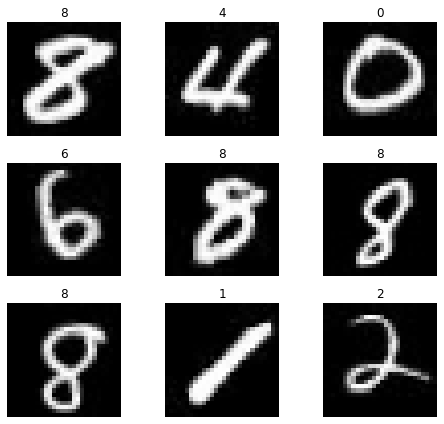

In [19]:
data.show_batch(rows=3, figsize=(7,6))

In [20]:
print(data.classes)
len(data.classes),data.c

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


(10, 10)

In [21]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [34]:
#learn.unfreeze()
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.158326,0.072784,0.022698,01:38
1,0.129190,0.091706,0.026984,01:41
2,0.051279,0.068033,0.017143,01:42
3,0.034344,0.025378,0.006190,01:48
4,0.030880,0.022947,0.006032,01:45


# Results

In [32]:
interp = ClassificationInterpretation.from_learner(learn)

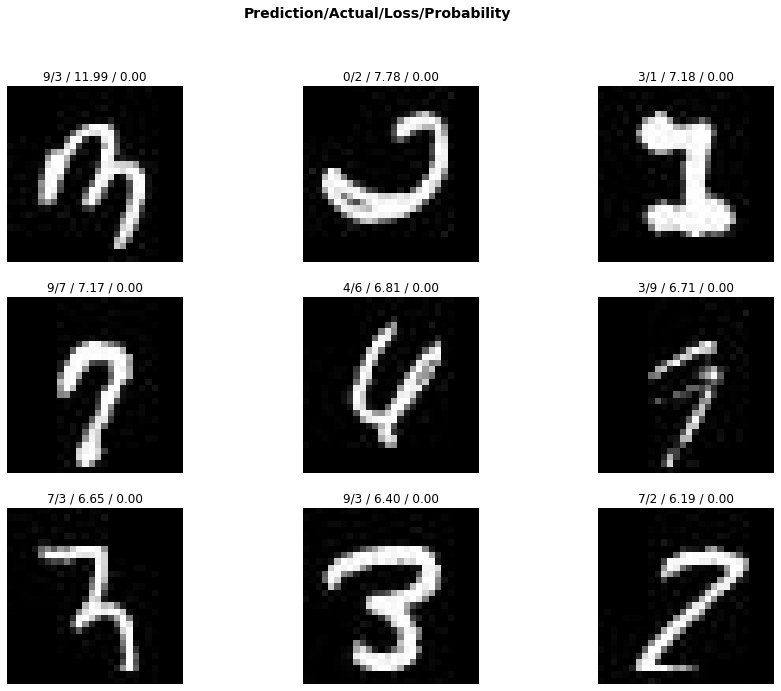

In [35]:
interp.plot_top_losses(9, figsize=(15,11))

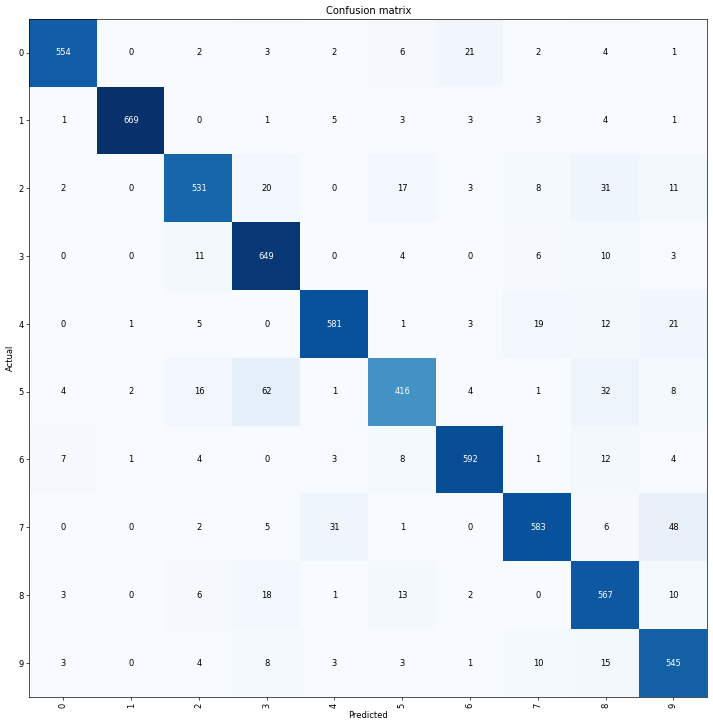

In [33]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Sample Submission for Kaggle

In [36]:
preds, y = learn.get_preds(DatasetType.Test)

In [30]:
preds[0].tolist()

[1.2015053698632983e-06,
 1.0369824849476572e-05,
 0.9971218705177307,
 0.0005726097733713686,
 0.00012910398072563112,
 6.751339697075309e-06,
 3.122019916190766e-05,
 0.000536763109266758,
 0.00156312994658947,
 2.689301982172765e-05]

In [52]:
class_score = np.argmax(preds, axis=1)

In [70]:
ImageId = [os.path.splitext(path)[0] for path in os.listdir('processed_data/test')]
ImageId = [int(path) for path in ImageId]
ImageId = [ID+1 for ID in ImageId]

In [79]:
submission  = pd.DataFrame({
    "ImageId": ImageId,
    "Label": class_score
})
submission.sort_values(by=["ImageId"], inplace = True)

In [81]:
submission.head()

,ImageId,Label
0,1,2
1,2,0
11112,3,9
20223,4,0
21334,5,3


In [83]:
submission.to_csv('kaggle_submission.csv', index = False)